In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

MULTILATERATION_METHOD = "2d"
samples_dir = Path("data/movement_2/")

In [137]:
# Try to get test environment conditions from JSON
import json

try:
    with open(samples_dir / "environment.json", "r") as file:
        settings = json.loads(file.read())
except:
    settings = dict()

if (TAG:=settings.get("tag")) is None:
    from data.points import TAG
if (ANCHORS := settings.get("anchors")) is None:
    from data.points import ANCHORS

In [138]:
class AccelerometerOrientation:
    x_sign: int
    global_x: str
    y_sign: int
    global_y: str

    def __init__(self, setting: str) -> None:
        """
        Module orientation
        The arrow should point the same way as the back of the module (accelerometer's Z axis)
        <------x-------
               ^       |
              -y       |
                       |
         <+x     -x>   y
                       |
              +y       |
               v       v
        """
        match setting:
            case "+x":
                data = (1, "acc_z", -1, "acc_y")
            case "-x":
                data = (-1, "acc_z", 1, "acc_y")
            case "+y":
                data = (1, "acc_y", 1, "acc_z")
            case "-y":
                data = (-1, "acc_y", -1, "acc_z")
            case _:
                raise ValueError(setting)

        self.x_sign, self.global_x, self.y_sign, self.global_y = data

ACCELEROMETER_ORIENTATION = AccelerometerOrientation(settings.get("acc_orientation") or "-y")

In [139]:
folder_name = samples_dir.name.upper()

MOVEMENT=False
REF_POINT="P1"
if folder_name.startswith("P"): 
    REF_POINT = samples_dir.name.upper()[:2]
else:
    MOVEMENT=True


# filenames = [
#     "data/p4/2023-07-04-23:02:13.565225living-room-p1-17.csv",
#     "data/p4/2023-07-04-22:48:07.757069living-room-p1-3.csv",
# ]
filenames = [f for f in samples_dir.iterdir() if f.name.endswith(".csv")]
filenames.sort()
# filenames

In [140]:
dfs = [pd.read_csv(f, index_col=0) for f in filenames]

In [141]:
# Enforce same number of samples
if not MOVEMENT:
    min_samples = min(len(df) for df in dfs)
    dfs = [df.head(min_samples) for df in dfs]

In [142]:
for df in dfs:
    df["timestamp"] = pd.to_datetime(df["timestamp"])

dfs = [df[df.anchor.isin(ANCHORS.keys())] for df in dfs]
dfs = [df.set_index("timestamp") for df in dfs]

anchors = dfs[0]["anchor"].unique()

# Multilateration

In [143]:
from multilateration.solve import solve

solved_dfs = [solve(df, ANCHORS, MULTILATERATION_METHOD) for df in dfs]

In [144]:
solved_dfs = [df.merge(solved_df, on="timestamp")[
    [
        "timestamp",
        "acc_x",
        "acc_y",
        "acc_z",
        "x",
        "y",
        "radius",
    ]
] for df, solved_df in zip(dfs, solved_dfs)]

# Convert to metric, remove gravitation
for df in solved_dfs:
    df[["x", "y"]] /= 1000
    df[["acc_x", "acc_y", "acc_z"]] *= 9.80665
    df[["acc_x", "acc_y", "acc_z"]] -= df[["acc_x", "acc_y", "acc_z"]].head(5).mean()


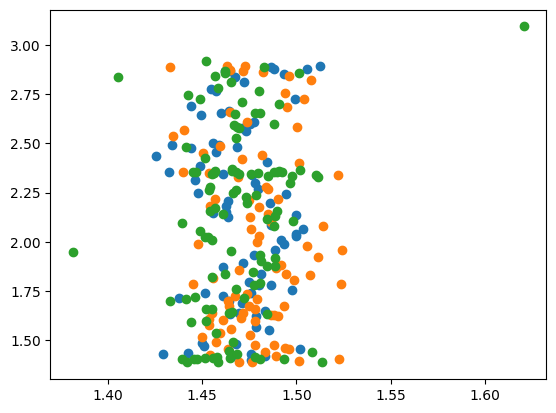

In [145]:
for df in solved_dfs:
    plt.scatter(df["x"], df["y"])
plt.show()

In [146]:
# Remove outliers
n_samples_before = sum(len(df) for df in solved_dfs)

def remove_outliers(df, columns, threshold=3):
    z_scores = np.abs((df[columns] - df[columns].mean()) / df[columns].std())
    df_no_outliers = df[(z_scores < threshold).all(axis=1)]
    return df_no_outliers

# Remove outliers from the DataFrame
solved_dfs = [remove_outliers(df, ['x', 'y']) for df in solved_dfs]
n_samples_after = sum(len(df) for df in solved_dfs)
display(f"Deleted {n_samples_before-n_samples_after} samples. Left {n_samples_after} out of {n_samples_before} samples.")

'Deleted 2 samples. Left 274 out of 276 samples.'

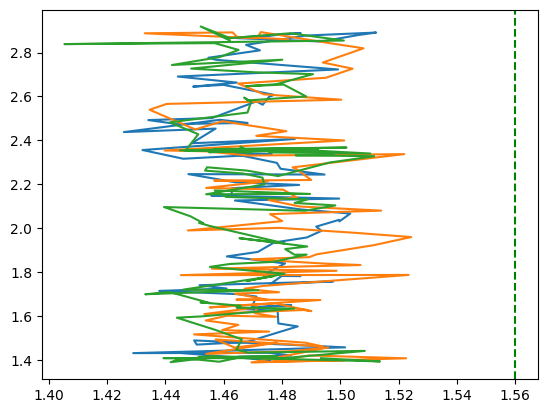

In [147]:
for df in solved_dfs:
    if MOVEMENT:
        plt.plot(df["x"], df["y"])
    else:
        plt.scatter(df["x"], df["y"])


if MOVEMENT:
    plt.axvline(TAG[REF_POINT][0] / 1000, color="green", linestyle="--")
plt.show()

In [148]:
from math import sqrt
def p2p_dist(ax, ay, bx, by):
    return sqrt((bx - ax) ** 2 + (by - ay) ** 2)

def point_line_distance(x, y, a, b, c):
    return abs(a * x + b * y + c) / sqrt(a**2 + b**2)

In [149]:
if MOVEMENT:
    # ax + by + c = 0
    a = 1
    b = 0
    c = - TAG[REF_POINT][0] / 1000
    calc_dist = lambda x: point_line_distance(x[0], x[1], a, b, c)
else:
    calc_dist = lambda x: p2p_dist(x[0], x[1], TAG[REF_POINT][0] / 1000, TAG[REF_POINT][1] / 1000)

for df in solved_dfs:
    df["error"] = df[["x", "y"]].apply(calc_dist, axis=1)
    

# Kalman filter

In [150]:
def kalman_step(x, P, measurement, R, motion, Q, F, H):
    # PREDICT x, P based on motion
    x = F * x + motion
    P = F * P * F.T + Q

    # UPDATE x, P based on measurement m
    # distance between measured and current position-belief
    y = np.matrix(measurement).T - H * x
    S = H * P * H.T + R  # residual convariance
    K = P * H.T * S.I  # Kalman gain
    x = x + K * y
    I = np.matrix(np.eye(F.shape[0]))  # identity matrix
    P = (I - K * H) * P

    return x, P

In [151]:
kalman_dfs = []
for df in solved_dfs:
    dt = df["timestamp"].diff().mean().to_pytimedelta().microseconds / 10**6

    F = np.matrix(
        [[1, 0, dt**2 / 2, 0], [0, 1, 0, dt**2 / 2], [0, 0, 1, 0], [0, 0, 0, 1]]
    )
    H = np.matrix(np.eye(4))

    # Q = np.matrix(np.diag([0.01, 0.01, 0.01, 0.01]))
    Q = np.matrix(np.diag([0.000001, 0.000001, 1000000, 1000000]))
    R = np.matrix(
        np.diag(
            [
                df["x"].std() ** 2,
                df["y"].std() ** 2,
                df[ACCELEROMETER_ORIENTATION.global_x].std() ** 2,
                df[ACCELEROMETER_ORIENTATION.global_y].std() ** 2,
            ]
        )
    )

    P = np.matrix(np.eye(4)) * 100
    x = np.matrix("0. 0. 0. 0.").T


    # Filter
    filtered = []
    motion = np.matrix("0. 0. 0. 0.").T
    for _, measurement in df[
        [
            "x",
            "y",
            ACCELEROMETER_ORIENTATION.global_x,
            ACCELEROMETER_ORIENTATION.global_y,
        ]
    ].iterrows():
        measurement = measurement.to_list()
        measurement = [
            measurement[0],  # x
            measurement[1],  # y
            ACCELEROMETER_ORIENTATION.x_sign * measurement[2],  # x
            ACCELEROMETER_ORIENTATION.y_sign * measurement[3],  # y
        ]
        x, P = kalman_step(x, P, measurement, R, motion, Q, F, H)
        filtered.append(x.tolist())

    filtered_pos = [[x[0], y[0]] for (x, y, _, _) in filtered]
    kalman_dfs.append(pd.DataFrame(filtered_pos, columns=["x", "y"]))

len(kalman_dfs)

3

In [152]:
for kalman_df in kalman_dfs:
    kalman_df["error"] = kalman_df.apply(calc_dist, axis=1)

In [153]:
import plotly.express as px
import plotly.graph_objects as go

# for i, df in enumerate(solved_dfs):
#     plt.plot(df["error"], label=i)
# plt.legend()
# plt.show()

data = {i: df for i, df in enumerate(solved_dfs)}
fig = go.Figure()

for i in data:
    fig = fig.add_trace(go.Line(y = data[i]["error"], 
                                   name = i))
fig.show()

/home/piotr/Documents/mgr/uwb-rs/data-processing/.venv/lib/python3.11/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




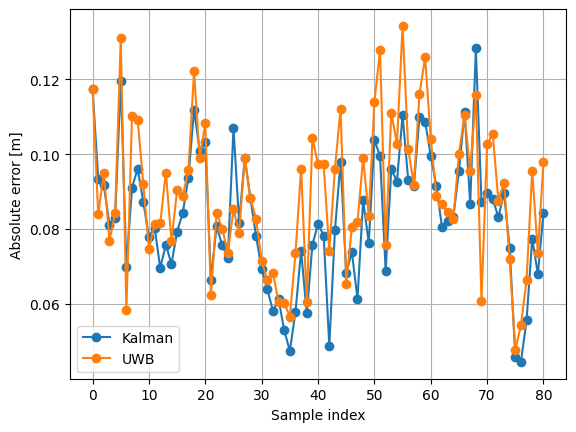

In [154]:
plt.plot(kalman_dfs[0]["error"], "-o", label="Kalman")
plt.plot(solved_dfs[0]["error"], "-o", label="UWB")
plt.legend()
plt.ylabel("Absolute error [m]")
plt.xlabel("Sample index")
plt.grid(True)
plt.show()

# Mean

In [155]:
all_kalman = pd.concat(kalman_dfs, ignore_index=True)
all_uwb = pd.concat(solved_dfs, ignore_index=True)

In [156]:
kalman = pd.concat(kalman_dfs)
kalman = kalman.groupby(kalman.index).mean()

solved = pd.concat(solved_dfs)
solved = solved[["x", "y", "error"]]
solved = solved.groupby(solved.index).mean()

dt = all_uwb["timestamp"].diff().mean().to_pytimedelta().microseconds / 10**6

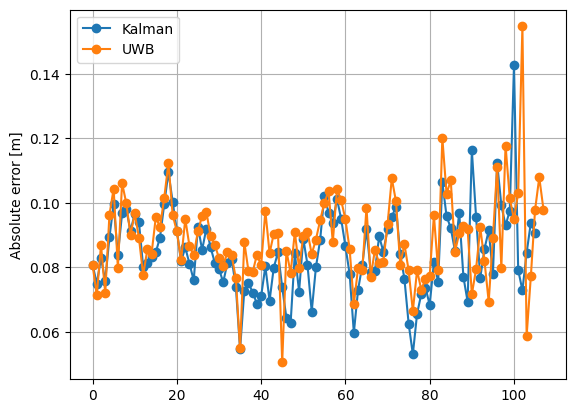

In [157]:
# x = [n * dt for n in range(len(solved))]
plt.plot(kalman["error"], "-o", label="Kalman")
plt.plot(solved["error"], "-o", label="UWB")
plt.legend()
plt.ylabel("Absolute error [m]")
# plt.xlabel("Time [s]")
plt.grid(True)
plt.show()

In [158]:
# for df, kdf in zip(solved_dfs, kalman_dfs):
#     plt.plot(kdf.x, kdf.y, color="blue")
#     plt.plot(df.x, df.y, color="orange")
#     plt.axvline(TAG[REF_POINT][0] / 1000, color="g", linestyle="--")
#     plt.show()

In [159]:
import seaborn as sns

x_y_comparison_df = pd.concat([all_kalman.copy().assign(name="Kalman"), all_uwb[["x", "y", "error"]].copy().assign(name="UWB")])

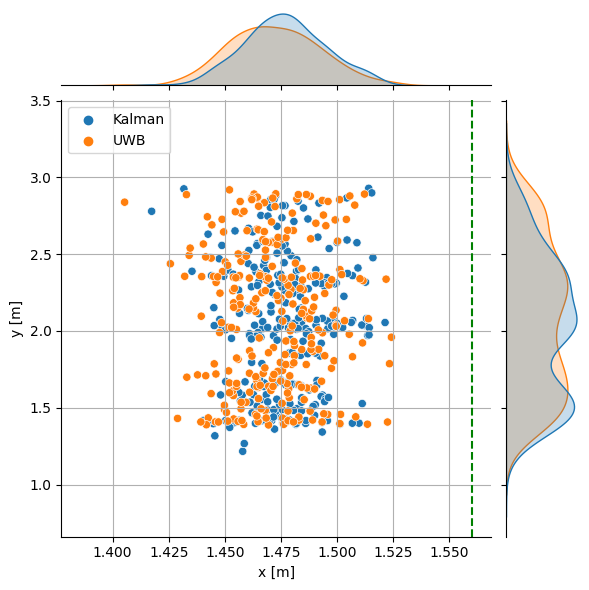

In [160]:

# plt.title("Bivariate distribution of positioning results.")
if MOVEMENT:
    sns.jointplot(
        data=x_y_comparison_df,
        x="x",
        y="y",
        hue="name",
        # kind="kde",
        # bw_adjust=0.9,
    )
    # for df in kalman_dfs:
    #     plt.plot(df.x, df.y, color="blue")
    # for df in solved_dfs:
    #     plt.plot(df.x, df.y, color="orange")
    plt.axvline(TAG[REF_POINT][0] / 1000, color="g", linestyle="--")
else:    
    sns.jointplot(
        data=x_y_comparison_df,
        x="x",
        y="y",
        hue="name",
        kind="kde",
        # bw_adjust=0.9,
    )
    plt.plot(TAG[REF_POINT][0] / 1000, TAG[REF_POINT][1] / 1000, "b1")
ax = plt.gca()
plt.xlabel("x [m]")
plt.ylabel("y [m]")
ax.get_legend().set_title("")
plt.grid()
plt.show()

# RMSE

In [161]:
errors = pd.concat(
    [all_kalman["error"], all_uwb["error"]],
    axis=1,
    keys=["Kalman (UWB+accelerometer)", "UWB"],
)
rmse = np.sqrt(errors.apply(lambda x: x**2, axis=1).mean())

rmse, rmse.diff()

(Kalman (UWB+accelerometer)    0.085225
 UWB                           0.090217
 dtype: float64,
 Kalman (UWB+accelerometer)         NaN
 UWB                           0.004992
 dtype: float64)

# Standard deviation

In [162]:
(e_std:=errors.std()) , e_std.diff()

(Kalman (UWB+accelerometer)    0.018009
 UWB                           0.019997
 dtype: float64,
 Kalman (UWB+accelerometer)         NaN
 UWB                           0.001988
 dtype: float64)